In [1]:
import torch
import tensorflow as tf
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
import time
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from resnet import resnet50

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [2]:
#os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
torch.cuda.empty_cache()

In [5]:
transform = transforms.ToTensor()

In [6]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [44]:
image = cv2.imread(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Train\001.jpg')
label = cv2.imread(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Train\001.png')

In [45]:
 image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [46]:
#label = label[:,:,0]
label[label == 2] = 1
label[label == 1] = 255

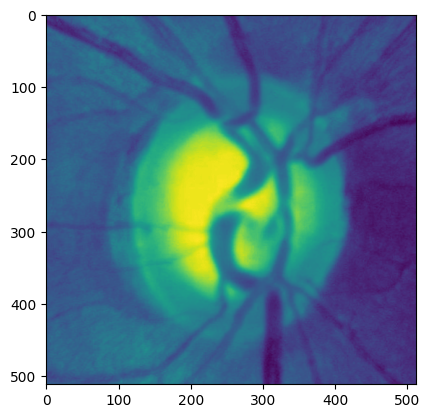

In [47]:
plt.imshow(image)

In [48]:
print(label.shape)

(512, 512, 3)


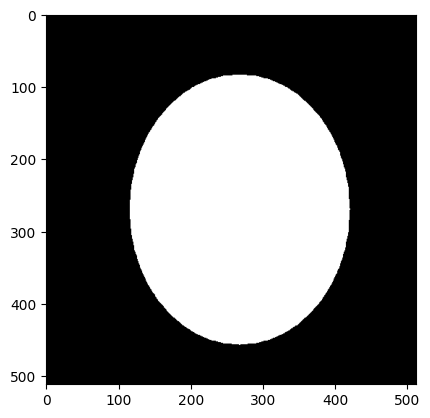

In [49]:
plt.
plt.imshow(label)

In [13]:
unique_values, counts = np.unique(label, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    502259
255:    95270


In [14]:
label.shape

(773, 773)

In [15]:
unique_values, counts = np.unique(label, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

0:    502259
255:    95270


In [16]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = cv2.imread(self.image_paths + "\/" + image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        label = cv2.imread(self.label_paths + "\/" +label_path)
        label = label[:,:,0]

        #label = loadmat(self.label_paths + "\/" +label_path).get('mask')

        
        label[label == 2] = 1
        label[label == 1] = 255

        if self.transform:
            image = Image.fromarray(image) 
            image = self.transform(image)#.to(device)
            #image = image/255

            label = Image.fromarray(label)
            label = self.transform(label)
        
        return image, label

In [17]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128), antialias=True),
    transforms.ToTensor(),
])

In [18]:
train_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Train', r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Train', data_transform)
valid_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Images_Cropped\Valid', r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Masks_Cropped\Valid', data_transform)

In [19]:
batchSize = 64
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

In [20]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, padding=0, stride=1, dilation=1, bias=False):
        super(ConvBlock, self).__init__()
        padding = (kernel_size + (kernel_size - 1) * (dilation - 1)) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.convInst = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
            nn.ReLU()
        )

    def forward(self, x):
        if x.shape[-2] == 1 and x.shape[-1]==1:
             out = self.convInst(x)
        else:
            out = self.conv(x)
        return out

In [21]:
def upsample(input, size=None, scale_factor=None, align_corners=False):
    out = F.interpolate(input, size=size, scale_factor=scale_factor, mode='bilinear', align_corners=align_corners)
    return out

In [22]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels):
        super(PyramidPooling, self).__init__()
        self.pooling_size = [1, 2, 3, 6]
        self.channels = in_channels // 4
        
        self.pool1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[0]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[1]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[2]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

        self.pool4 = nn.Sequential(
            nn.AdaptiveAvgPool2d(self.pooling_size[3]),
            ConvBlock(in_channels, self.channels, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.pool1(x)
        out1 = upsample(out1, size=x.size()[-2:])

        out2 = self.pool2(x)
        out2 = upsample(out2, size=x.size()[-2:])

        out3 = self.pool3(x)
        out3 = upsample(out3, size=x.size()[-2:])

        out4 = self.pool4(x)
        out4 = upsample(out4, size=x.size()[-2:])

        out = torch.cat([x, out1, out2, out3, out4], dim=1)
        return out


In [23]:
class PSPNet(nn.Module):
    def __init__(self, n_classes=64, n_out_classes=1):
        super(PSPNet, self).__init__()
        self.out_channels = 512

        self.backbone = resnet.resnet34(pretrained=True)
        self.stem = nn.Sequential(
            *list(self.backbone.children())[:4],
        )
        self.block1 = self.backbone.layer1
        self.block2 = self.backbone.layer2
        self.block3 = self.backbone.layer3
        self.block4 = self.backbone.layer4

        self.depth = self.out_channels // 4
        self.pyramid_pooling = PyramidPooling(self.out_channels)
        
        self.decoder = nn.Sequential(
            ConvBlock(self.out_channels * 2, self.depth, kernel_size=3),
            nn.Dropout(0.1),
            nn.Conv2d(self.depth, n_out_classes, kernel_size=1),
        )

        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax()
        
    def forward(self, x, label=None):
        out = self.stem(x)
        out1 = self.block1(out)
        out2 = self.block2(out1)
        out3 = self.block3(out2)
        out4 = self.block4(out3)
        
        out = self.pyramid_pooling(out4)
        out = self.decoder(out)
        out = upsample(out, size=x.size()[-2:])
        out = upsample(out, size=x.shape[-2:], align_corners=True)
        out = self.sigm(out)
        return out

In [24]:
num_epochs = 100  #25 epoch good
best_val_loss = float('inf')
early_stop_patience = 5
learning_rate = 0.0001
weight_decay = 0.001

In [25]:
model = PSPNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
print(model)

PSPNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

C:\Users\samko\Desktop\Files\UNI\DP\LinkNet\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\samko\Desktop\Files\UNI\DP\LinkNet\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
train_loss_list = []
valid_loss_list = [] 
total_accuracy = 0.0
total_iou = 0.0
total_samples = 0
success_epoch = 0
clip_value = 1

for epoch in range(num_epochs): 
    start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    
    success_epoch+=1
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model.train() 
    for images, labels in train_data: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels= labels.to(device) 
        #Calculating the model output and the cross entropy loss 
        outputs = model.forward(images) 
        # outputs = (outputs>0.5).float()
        # labels = (labels==1).float()
        # outputs.requires_grad = True
        
        # outputs = tf.where(outputs.cpu().detach().numpy() > 0.5, 1, 0)
        # labels =  tf.where(labels.cpu().detach().numpy() == 1, 1, 0)
        # with device:
        #     outputs = tf.identity(outputs)
        #     labels = tf.identity(labels)
        loss = criterion(outputs, labels) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        train_loss += loss.item() 
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_data):
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images) 

            # outputs = (outputs>0.5).float()
            # labels = (labels==1).float()
            # outputs.requires_grad = True
            
            # outputs = tf.where(outputs.cpu().detach().numpy() > 0.5, 1, 0)
            # labels =  tf.where(labels.cpu().detach().numpy() == 1, 1, 0)
            # with device:
            #     outputs = tf.identity(outputs)
            #     labels = tf.identity(labels)
            
            loss = criterion(outputs, labels)
        
            valid_loss += loss.item() 

    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stop_patience:
            break
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data))
    valid_loss_list.append(valid_loss/len(valid_data)) 
    print(f"Time:{time.time() - start_time} sec   Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]}")# IoU_train = {average_iou_train}  Iou_valid = {average_iou_valid} Accuracy_train = {average_accuracy_train} Accuracy_valid = {average_accuracy_valid}") #  DICE: {dice_coef}")      

Epoch 1/100: Time:6.830267429351807 sec   Training loss = 0.3914664685726166 Validation loss = 0.6963586807250977
Epoch 2/100: Time:6.125424861907959 sec   Training loss = 0.2502963934093714 Validation loss = 0.4690962880849838
Epoch 3/100: Time:6.1996214389801025 sec   Training loss = 0.22661766409873962 Validation loss = 0.28711697459220886
Epoch 4/100: Time:6.23980188369751 sec   Training loss = 0.21507960371673107 Validation loss = 0.250424824655056
Epoch 5/100: Time:6.173569440841675 sec   Training loss = 0.20672491379082203 Validation loss = 0.23869415372610092
Epoch 6/100: Time:6.217717170715332 sec   Training loss = 0.20042569376528263 Validation loss = 0.21906158328056335
Epoch 7/100: Time:6.128331661224365 sec   Training loss = 0.19450282119214535 Validation loss = 0.2104625478386879
Epoch 8/100: Time:6.134764671325684 sec   Training loss = 0.18931258097290993 Validation loss = 0.20152831822633743
Epoch 9/100: Time:6.0913238525390625 sec   Training loss = 0.18440430611371994 

In [27]:
# outputs = (outputs > 0.5).int()
# output = outputs[60,:,:,:]
# label = labels[60,:,:,:]

# output = output.to("cpu").detach().numpy().transpose(1,2,0)
# label = label.to("cpu").detach().numpy().transpose(1,2,0)



In [28]:
# unique_values, counts = np.unique(output, return_counts=True)
# for value, count in zip(unique_values, counts):
#     print(str(value) +":    "+str(count))

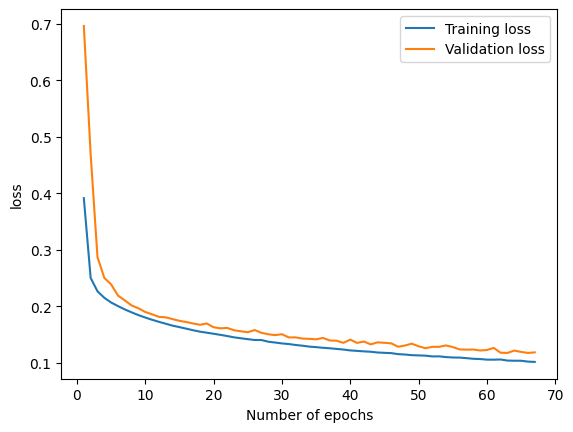

In [29]:
plt.plot(range(1,success_epoch), train_loss_list, label="Training loss") 
plt.plot(range(1,success_epoch), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [30]:
# plt.plot(range(1,success_epoch+1), train_loss_list, label="Training loss") 
# plt.plot(range(1,success_epoch+1), valid_loss_list, label="Validation loss") 
# plt.xlabel("Number of epochs") 
# plt.ylabel("loss") 
# plt.legend()

In [31]:
#folder = r''+folder_path+r'\Data'
folder = r''+folder_path+r'\NewData\CroppedCenteredData\CroppedCenteredData\Testing\PSPNet\Resnet34'
test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results_disk'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [32]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [33]:
model = torch.load(r''+folder_path+r'\SaveModels\PSPNet_Disk\PSPNet_resnet34_pretrained.pt')

(1, 256, 256)


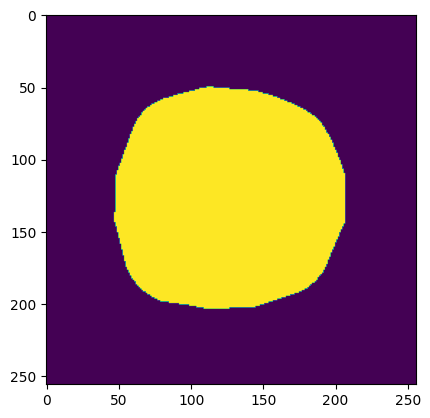

In [34]:
threshold = 0.5
model.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        orig_image = image
        image = image.resize((256, 256), resample=Image.NEAREST)
        #image = image.convert('L')
        image = transform(image)
        image = image.unsqueeze(0)

        image = image.to(device) 
        output = model(image)

        output = output.detach().cpu().numpy()[0]
        #output = output * 10
        output = (output > threshold)
        print(output.shape)
        output = np.transpose(output, (1, 2, 0))
        
        plt.imshow(output)
        break;
        # output_dict = {"mask": output}
        # savemat(test_results_folder + "\/" + filename.strip(".jpg") + ".mat", output_dict)

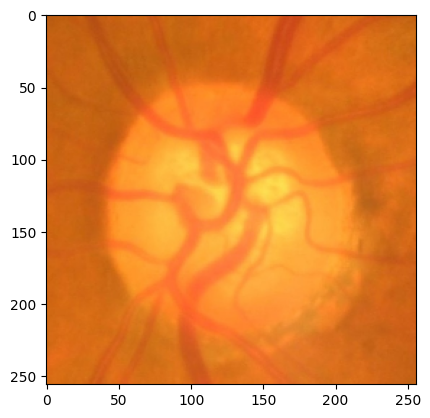

In [35]:
plt.imshow(np.transpose(image.squeeze().to('cpu').numpy(), (1, 2, 0)))

In [36]:
image = Image.open(test_folder + "\/" + "604.jpg")
#label = loadmat(test_gt_folder + "\/" + "646.mat").get("mask")
label = Image.open(test_gt_folder + "\/" + "604.png")

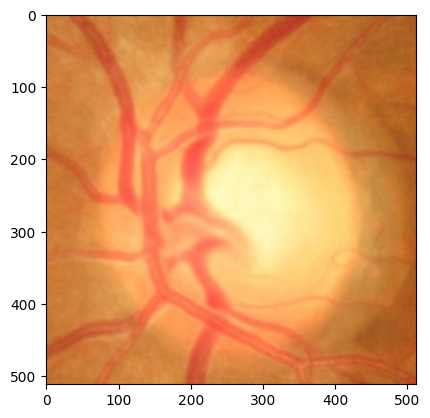

In [37]:
plt.imshow(image)

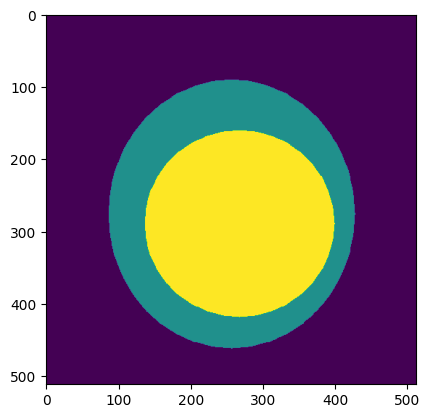

In [38]:
plt.imshow(label)

(1, 256, 256)


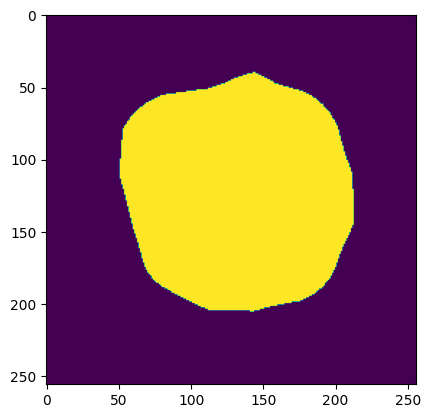

In [39]:
threshold = 0.5
model.eval()
image = image.resize((256, 256), resample=Image.NEAREST)
#image = image.convert('L')
image = transform(image)
image = image.unsqueeze(0)

image = image.to(device) 
output = model(image)

output = output.detach().cpu().numpy()[0]
#output = output * 10
output = (output > threshold)
print(output.shape)
output = np.transpose(output, (1, 2, 0))

plt.imshow(output)

In [40]:
unique_values, counts = np.unique(output, return_counts=True)
for value, count in zip(unique_values, counts):
    print(str(value) +":    "+str(count))

False:    44261
True:    21275


In [41]:
np.max(output)

True

In [42]:
#torch.save(model, r''+folder_path+r'\SaveModels\PSPNet_Disk\PSPNet_resnet34_pretrained.pt')

In [43]:
#torch.save(model.state_dict(), r''+folder_path+r'\SaveModels\PSPNet_Disk\PSPNet_resnet34_pretrained_state_dict.pt')